Try and keep it to cpu rather than gpu
1. have a couple options for embedding styles (pass function into another function)
2. use pillow histogram initially

In [406]:
import pynndescent # https://pynndescent.readthedocs.io/en/latest/how_to_use_pynndescent.html#Nearest-neighbors-of-the-training-set
from PIL import Image # Pillow
import os # for getting filenames

from concurrent.futures import ThreadPoolExecutor # for parallel processing
from tqdm import tqdm # for progress bars

import numpy as np

### Embedding options ###
## VGG16 ##
from torch.utils.data import DataLoader
from dataset import ImageDataset
from torchvision import transforms
import torch
from torchvision import models
## Surf ##
import cv2 as cv

## Clip ##
from imgbeddings import imgbeddings # ensure using huggingface-hub v0.25.0 or earlier to prevent import issue


import random

random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)
#! set nearest neighbour random seed
#! set it for each important cell


IMAGE_FOLDER = './images'

# 1. Load images 

consider making sure the way to read through images in flexible (walk through folders), keep zip in same format

In [407]:
image_filenames = np.array(os.listdir(path=IMAGE_FOLDER))
# image_filenames[0:3]

In [408]:
with Image.open(os.path.join(IMAGE_FOLDER, image_filenames[0])) as img:
    print(type(img))
#     print(img.histogram()) # Colour histogram
    # display(img)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


# 2. "Embedding"
Make a function that takes in a list of filenames and an embedding function and returns "embedding graph"

The format is that the ith row of "embedding" corresponds to the ith filename in image_filenames

In [409]:
#! use scikit image for sift 
# def get_descriptors_opencv(f=cv.SIFT_create()):
#     # https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format

#     def embed(img: "pillow image"):
#         open_cv_img = np.array(img.convert('RGB'))[:, :, ::-1].copy()

#         # Use sift as surf patented
#         # surf = cv.SURF(400) #? add way to change paramts 
#         _, des = f.detectAndCompute(open_cv_img,None)
#         #! add clustering on the outputs (do single layer feature network first)

#         # Convert RGB to BGR
#         return np.array(des).flatten()
    
#     return embed

def get_clip_embedding(image_filenames):
    # want to feed it in batches
    images = [Image.open(os.path.join(IMAGE_FOLDER, image_filename)) for image_filename in image_filenames] # try as generator
    # for 
    ibed = imgbeddings()
    embedding = ibed.to_embeddings(images)
    return embedding


#* look into different colour spaces with luminance 
#! integrate scikit image 
def get_normalised_histogram(img: "pillow image") -> "numpy array":
    """Returns a pixel standardised pillow colour histogram array."""
    w, h = img.size
    pixels = w*h
    return np.array(img.histogram())/pixels

# embedding_function takes a batch of images, get_embedding takes batch_size=
def get_embedding(image_filenames = [], embedding_function = get_normalised_histogram) -> "[embedding_function(img_0),...]":
    """ 
    A function to get embeddings, this does not work well for intensive embeddings which benefit from batching.

    Params:
        - image_filenames: list of filenames within IMAGE_FOLDER.
        - embedding_function: a function which takes in <class 'PIL.JpegImagePlugin.JpegImageFile'>
        and returns a 1D array of floats (by defauly creates colour histogram).

    Returns:
        - embedding: list of embedding where the ith row in embedding.
        corresponds to the ith image_filename in image_filenames.

    #! assumption: assume the order is consistent 
    """

    def process_image(image_filename):
        with Image.open(os.path.join(IMAGE_FOLDER, image_filename)) as img:
            return embedding_function(img) # add the embedding of the image to the given function
        
    with ThreadPoolExecutor() as executor:
        embedding = list(tqdm(executor.map(process_image, image_filenames), total=len(image_filenames)))

    return np.array(embedding) # tqdm does not work without the list()

#### Try to play with pytorch batching

In [410]:
# Import custom tensor dataset from other file
dataset = ImageDataset(image_filenames=image_filenames, root_dir=IMAGE_FOLDER, 
                       transform= transforms.Compose([
                           transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
                           transforms.ToTensor(),         # Convert image to tensor
                           transforms.Normalize(          # Normalize using ImageNet statistics
                            mean=[0.485, 0.456, 0.406],  # Mean for RGB channels
                            std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
                                )
    ]))

#todo Look into optimising these values
dataloader = DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=4, prefetch_factor=2)

# https://pytorch.org/vision/main/models/vgg.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights 

def get_embeddings_pytorch(dataloader, pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")):

    pytorch_model.eval()  # optimization (disable unneeded things)

    torch.set_grad_enabled(False)  # optimization (disable unneeded things)


    batch_embeddings = []  # Using a list to hold embeddings for each image
    batch_filenames = []

    for i_batch, (batch, filenames) in enumerate(dataloader):
    #     print("Start loop:", i_batch)
        
        with torch.no_grad():  # Disable gradient calculations for inference
            output = pytorch_model(batch)

        # The output is logits; apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Convert to numpy array
        probabilities_numpy = probabilities.detach().cpu().numpy()

        print(f'\rCompleted batch: {i_batch+1}/{len(dataloader)}', end='', flush=True) # overwrite prev update message
        
        # Store each batch's probabilities with corresponding filenames
        batch_embeddings.extend(probabilities_numpy)  # Add probabilities for each image
        batch_filenames.extend(filenames)  # Add corresponding filenames

    return np.array(batch_embeddings), np.array(batch_filenames)

In [524]:
%%time
#### Get embedding without batching ####
# embedding_function = get_pytorch_embedding_function()
# embedding_function=get_descriptors_opencv()
# embedding_function = get_normalised_histogram
# embedding = get_embedding(image_filenames=image_filenames, embedding_function=embedding_function) 
# np.save("./output/image_embedding_hist.npy", embedding)
# np.save("./output/image_filenames_hist.npy", image_filenames) # this is to keep a consistent log of the index
# using ThreadPoolEexecutor speed up from 15s to 3s

#### Get embedding with batching (for pytorch) ####
# batch_embeddings, batch_filenames = get_embeddings_pytorch(dataloader)
# np.save("./output/image_embedding_vgg16.npy", batch_embeddings)
# np.save("./output/image_filenames_vgg16.npy", batch_filenames)
# CPU times: user 5min 35s, sys: 25.6 s, total: 6min
# Wall time: 2min 10s

# embeddding vgg16 all images 
# CPU times: user 3h 48min 31s, sys: 4min 30s, total: 3h 53min 1s
# Wall time: 48min 13s


### Get embedding CLIP ####
# clip_embeddings = get_clip_embedding(image_filenames)
# np.save("./output/image_embedding_clip.npy", clip_embeddings)
# np.save("./output/image_filenames_clip.npy", image_filenames) # this is to keep a consistent log of the index

#### Load Embeddings ####
## Colour Histogram ##
# embedding = np.load("./output/image_embedding_hist.npy")
# image_filenames = np.load("./output/image_filenames_hist.npy")
## VGG16 ##
# embedding = np.load("./output/image_embedding_vgg16.npy")
# image_filenames = np.load("./output/image_filenames_vgg16.npy")
## CLIP ##
embedding = np.load("./output/image_embedding_clip.npy")
image_filenames = np.load("./output/image_filenames_clip.npy")


CPU times: user 1.49 ms, sys: 10 ms, total: 11.5 ms
Wall time: 55.5 ms


# 3. Get KNN

In [525]:
def get_knn(embedding, n_neighbours=10) -> ("nearest_neighbours_array", "neighbours_distance_array"):
    """
    Params:
        - embedding: numpy array of embeddings. #? not a great description
        - n_neighbours: number of nearest neighbours returned.

    Returns:
        - nearest_neighbour_array: an array where the ith row corresponds to the n
        nearest neighbours for the ith point.
        - neighbours_distance_array: an array where the ith row corresponds to 
        the distances of the n nearest neighbours from the ith point.
    """
    index = pynndescent.NNDescent(embedding, n_neighbors=n_neighbours, random_state=42)
    return index.neighbor_graph # nearest_neighbours_array, neighbours_distance_array 

In [526]:
%%time
number_of_neighbours = 10
nearest_neighbours_array, neighbours_distance_array = get_knn(embedding, number_of_neighbours)
np.save(f"./output/{number_of_neighbours}_nearest_neighbours.npy", nearest_neighbours_array)
np.save(f"./output/{number_of_neighbours}_nearest_neighbours_distance.npy", neighbours_distance_array)


# #* You can read from the saved file by uncommenting this code and commenting above
# number_of_neighbours_load = 10
# nearest_neighbours_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours.npy")
# neighbours_distance_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours_distance.npy")

CPU times: user 101 ms, sys: 39.7 ms, total: 141 ms
Wall time: 135 ms


### 3.1 Make some analysis helper functions
First some functions for getting the most common neighbours

In [527]:
def get_count_neighbour_occurances(nearest_neighbours_array) -> "ranking_array":
    """return array where the ith index is how many times the ith number occured as a neighbour 
    (including as a neighbour of itself)"""
    _, counts = np.unique(nearest_neighbours_array.flatten(), return_counts=True) 
    return counts

In [528]:
def rank_neighbour_occurances(count_neighbour_occurances_array, ascending=True):
    """takes get_count_neighbour_occurances() or get_mean_distance() output as input and returns a ranked array 
    of indexes in desired order (the index corresponds to a filename in the image_filenames variable)"""
    # first part returns ascending list of sorted indices 
    # second part conditionally flips the order
    return np.argsort(count_neighbour_occurances_array)[::-1+2*ascending] # ascending = True -> 1,  ascending = False -> -1


now some functions for getting the mean distance of an image from its neighbours

In [529]:
def get_mean_distance(neighbours_distance_array, exclude_self=True):
    """Takes neighbours_distance_array and returns an array where the ith row
    is the mean distance across the n neighbours from the ith embedded image.

    This mean can conditionally include its distance from itself (0) in the mean calculation"""

    if exclude_self:
        mean_distances = np.mean(neighbours_distance_array[:, 1:], axis=1) # exclude first column if exclude_self

    else:
        mean_distances = np.mean(neighbours_distance_array, axis=1)
    return mean_distances

### 3.2 Getting K-means clusters

In [530]:
from sklearn.cluster import KMeans

def get_cluster_labels(embedding, n_clusters = 10, random_state=42) -> ['labels']:
    # add docstring
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(embedding)
    return kmeans.labels_

In [531]:
%%time
cluster_labels = get_cluster_labels(embedding, n_clusters=10)

CPU times: user 80.8 ms, sys: 32.1 ms, total: 113 ms
Wall time: 95.6 ms


# 4. Data exploration
first lets graph the most common neighbours

import dependencies

In [532]:
import matplotlib.pyplot as plt
import seaborn as sns

### 4.1 Most common neighbours

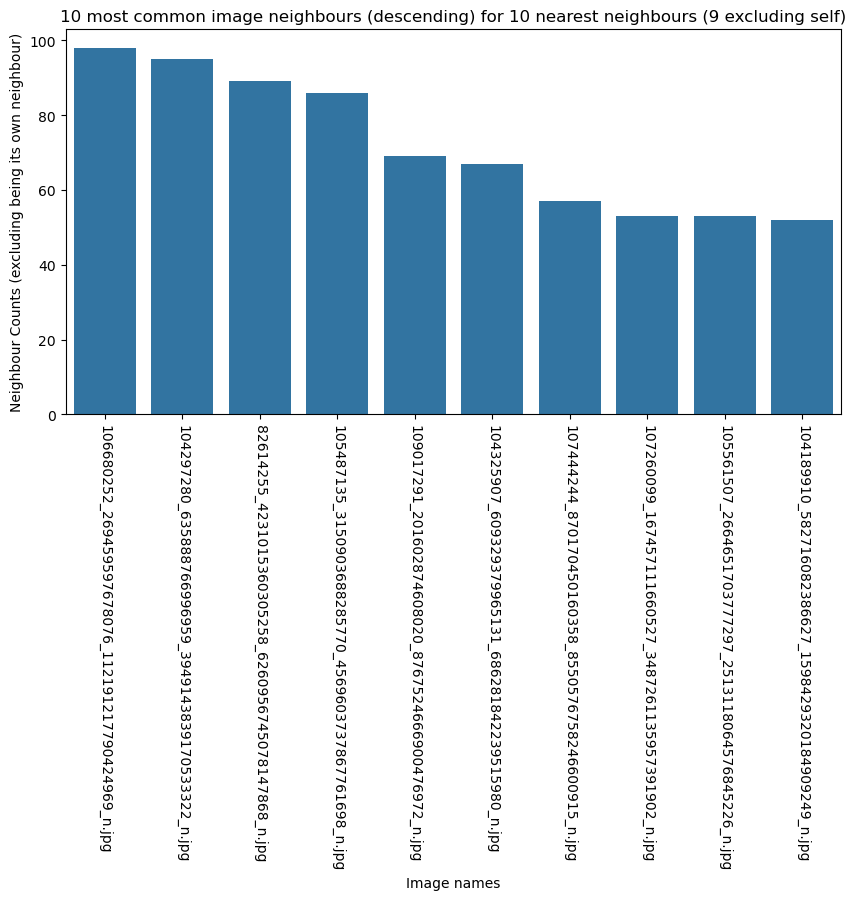

106680252_269459597678076_112191217790424969_n.jpg


In [533]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[count_neighbour_occurances_array[idx] -1 for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Neighbour Counts (excluding being its own neighbour)")
plt.title(f"{n_most_common} most common image neighbours (descending) for 10 nearest neighbours (9 excluding self)")

plt.show()
print(x[0])

show the top image neighbour

In [534]:
# with Image.open(os.path.join(IMAGE_FOLDER, x[0])) as img:
#     display(img)

### 4.2 Closest image to its neighbours (average)

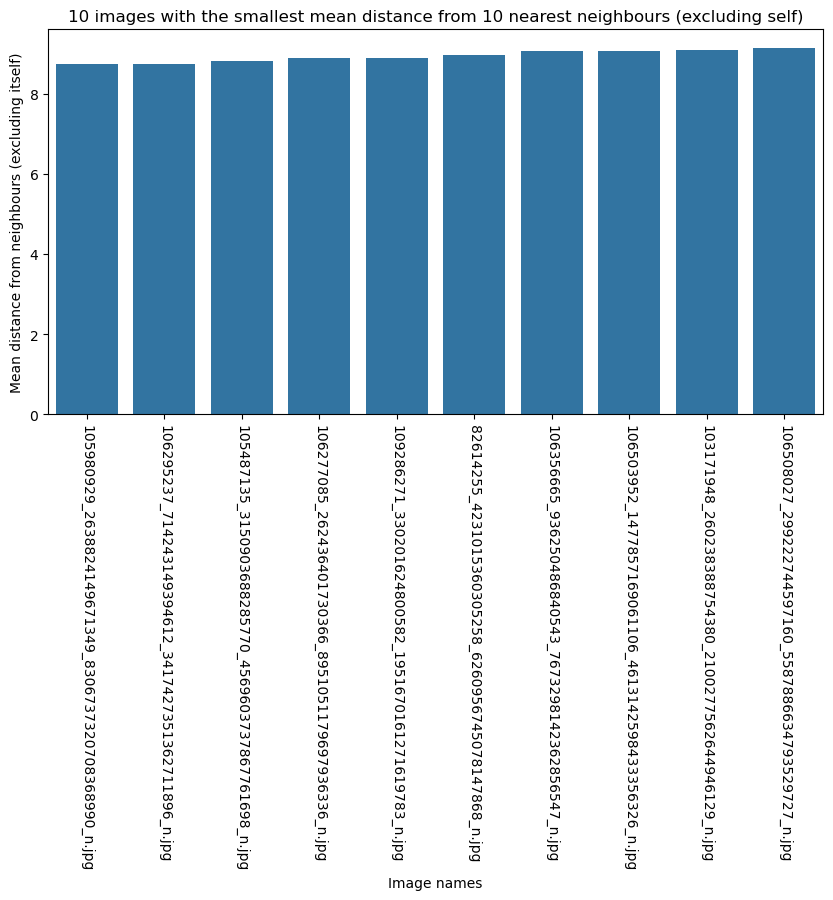

105980929_2638824149671349_8306737320708368990_n.jpg


In [535]:
neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
ranked_neighbour_occurances = rank_neighbour_occurances(neighbours_mean_distance_array, ascending=True)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[neighbours_mean_distance_array[idx] for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Mean distance from neighbours (excluding itself)")
plt.title(f"{n_most_common} images with the smallest mean distance from 10 nearest neighbours (excluding self)")

plt.show()
print(x[0])

Show the "closest" neighbour

In [536]:
# with Image.open(os.path.join(IMAGE_FOLDER, x[0])) as img:
#     display(img)

### 4.3 Histogram for times an image appears as a nearest neighbour

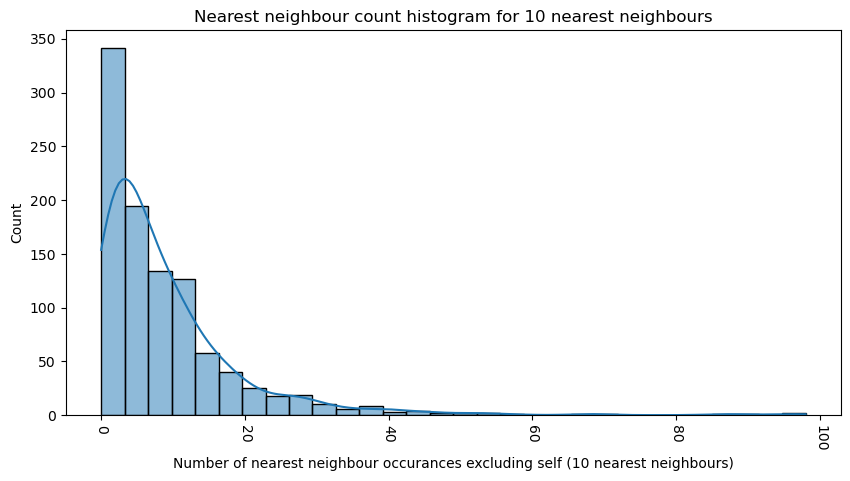

In [537]:
sorted_count_neighbour_occurances_array = np.sort(get_count_neighbour_occurances(nearest_neighbours_array))-1 # -1 to exclude self

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_count_neighbour_occurances_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"Number of nearest neighbour occurances excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"Nearest neighbour count histogram for {number_of_neighbours} nearest neighbours")

plt.show()


### 4.4 Histogram for an images mean distance across its neighbours

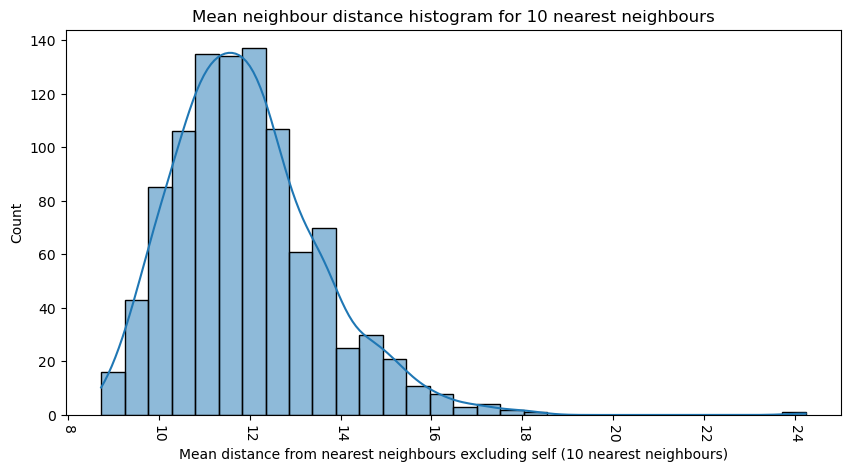

In [538]:
log = False

if log:
    sorted_mean_distance_array = np.log(np.sort(get_mean_distance(neighbours_distance_array)))
    title = "Log mean"
else:
    sorted_mean_distance_array = np.sort(get_mean_distance(neighbours_distance_array))
    title = "Mean"

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_mean_distance_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"{title} distance from nearest neighbours excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"{title} neighbour distance histogram for {number_of_neighbours} nearest neighbours")

plt.show()


### 4.5 Visualise the embeddings for the most and least common nearest neighbours

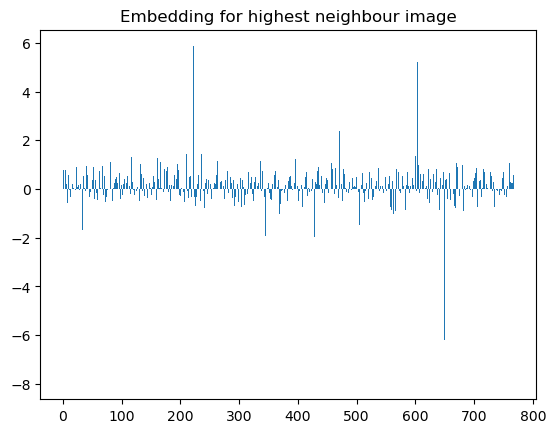

In [539]:
max_index = np.argmax(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[max_index])), embedding[max_index])
plt.title("Embedding for highest neighbour image")
plt.show()

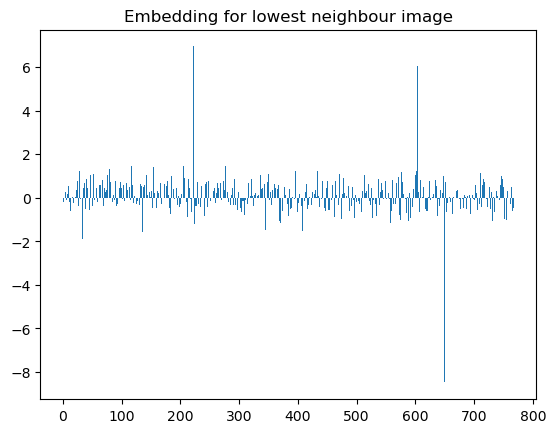

In [540]:
min_index = np.argmin(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[min_index])), embedding[min_index])
plt.title("Embedding for lowest neighbour image")
plt.show()


### 4.6 Force directed diagram
create an interactive "network plot" with a heatmap for aid in visualisation. Use different colours for each cluster.

1. Overall diagram
2. Diagram for each cluster

In [541]:
import networkx as nx
from scipy.stats import gaussian_kde
import pandas as pd
import plotly.graph_objects as go
from matplotlib import colormaps


In [542]:
%%time
# nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(data)
# distances, indices = nbrs.kneighbors(data)

# Create the graph
G = nx.Graph()
for i, neighbors in enumerate(nearest_neighbours_array):
    for neighbor in neighbors:
        if i != neighbor:  # Avoid self-loops
            # add a very small number to prevent divide by 0, is there a better way to handle this?
            weight = 1/((neighbours_distance_array[i][np.where(nearest_neighbours_array[i] == neighbor)[0][0]])+1e-20)
            G.add_edge(i, neighbor, weight=weight)

# Visualize the graph
# key value pair of index and position
pos = nx.spring_layout(G, iterations=100, seed=42, k=None, weight='weight')  # Use spring layout for positioning
# nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=100)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

position_df = pd.DataFrame(data={"index":list(pos.keys()),"x":np.array(list(pos.values()))[:,0],"y":np.array(list(pos.values()))[:,1]})

CPU times: user 3.96 s, sys: 93.9 ms, total: 4.06 s
Wall time: 4.39 s


In [543]:
# Compute the KDE using scipy
kde = gaussian_kde([position_df['x'], position_df['y']])
grid = np.linspace(min(position_df['x'].min(), position_df['y'].min()), 
                   max(position_df['x'].max(), position_df['y'].max()),
                   100) # done this way to make square plot
# xgrid = np.linspace(position_df['x'].min(), position_df['x'].max(), 100)
# ygrid = np.linspace(position_df['y'].min(), position_df['y'].max(), 100)
X, Y = np.meshgrid(grid, grid)

# Evaluate the KDE on the grid
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

colours = [colormaps.get_cmap("tab20")(value) for value in np.linspace(0,1,len(set(cluster_labels)))]
colours = np.hstack((np.array(colours)[:,0:3]*255, np.array(colours)[:,3:4])) 
rgba_colours = [
    f"rgba({','.join(str(int(num)) for num in colours[label])})"
    for label in cluster_labels
]

fig = go.Figure()

fig.add_trace(go.Contour(
    z=Z, x=grid, y=grid, colorscale='Inferno',
    contours=dict(
        showlabels=True, labelfont=dict(size=12), coloring='heatmap'
    ),
    colorbar=dict(title='Density')
))

fig.add_trace(go.Scatter(x=position_df['x'],
                         y=position_df['y'], 
                         hovertext=position_df['index'],
                         mode='markers', 
                         marker=dict(
        symbol='circle',
        opacity=0.5,
        color=rgba_colours,
        size=4,
        line=dict(width=1),
    )))


fig.update_layout(
    xaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=20 ),
    yaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=20 ),
    title="Spring Visualisation for Image embeddings based off Nearest Neighbour Distance",
    autosize=False,
    height=800,
    width=800,
    hovermode='closest'
)
fig.write_image("output/springplot_clip.png")

fig.show()

Show all options as subplots

In [544]:
from plotly.subplots import make_subplots

subplot_rows = 4
subplot_cols = 3

# Compute the KDE using scipy
kde = gaussian_kde([position_df['x'], position_df['y']])
grid = np.linspace(min(position_df['x'].min(), position_df['y'].min()), 
                   max(position_df['x'].max(), position_df['y'].max()),
                   100) # done this way to make square plot
# xgrid = np.linspace(position_df['x'].min(), position_df['x'].max(), 100)
# ygrid = np.linspace(position_df['y'].min(), position_df['y'].max(), 100)
X, Y = np.meshgrid(grid, grid)

# Evaluate the KDE on the grid
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)


colours = [colormaps.get_cmap("tab20")(value) for value in np.linspace(0,1,len(set(cluster_labels)))]
colours = np.hstack((np.array(colours)[:,0:3]*255, np.array(colours)[:,3:4])) 

fig = make_subplots(rows=subplot_rows, cols=subplot_cols, subplot_titles=[f"Cluster {num}" for num in set(cluster_labels)])

location = (1,1)



for target_cluster in set(cluster_labels):


    rgba_colours = [
        f"rgba({','.join(str(num) for num in [255,255,255,1])})"
        if label == target_cluster else f"rgba({','.join(str(num) for num in [0,0,0,0])})"
        for label in cluster_labels
    ]



    fig.add_trace(go.Contour(
        z=Z, x=grid, y=grid, colorscale='Inferno',
        contours=dict(
            showlabels=True, labelfont=dict(size=12), coloring='heatmap'
        ),
        colorbar=dict(title='Density')
    ), row = location[0], col=location[1])

    fig.add_trace(go.Scatter(x=position_df['x'],
                            y=position_df['y'], 
                            hovertext=position_df['index'],
                            mode='markers', 
                            marker=dict(
            symbol='circle',
            opacity=0.5,
            color=rgba_colours,
            size=1,
            line=dict(width=0),
        )), row = location[0], col=location[1])


    if location[1] < subplot_cols:
        location = (location[0], location[1]+1)
    else: # go to new col
        location = (location[0]+1, 1)

fig.update_layout(
    # xaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=20 ),
    # yaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=20 ),
    title="Spring Visualisation for Embedding Clusters",
    autosize=False,
    height=1000,
    width=700,
    hovermode='closest',
    showlegend=False

)


fig.show()

# 5. HTML Export 

In [545]:
# This lists the avaliable colormaps for the cluster colouring, recommended tab10 or tab20 for good colour differentiation
from matplotlib import colormaps
# list(colormaps)

In [561]:
# regarding colour_map: If you are using above 20 clusters, try "viridis" or a similar continuous map
def generate_html(nearest_neighbours_array, neighbours_distance_array,image_filenames, cluster_labels, group_clusters=False, image_filepath = "../images/", colour_map="tab20"):
    """Generates string html file to display the images and relevant information"""
    count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
    ranked_indices = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)
    number_of_neighbours = len(nearest_neighbours_array[0])
    number_of_clusters = len(set(cluster_labels))

    colours = [colormaps.get_cmap(colour_map)(value) for value in np.linspace(0,1,number_of_clusters)]

    neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)

    max_neighbour_occurances = max(count_neighbour_occurances_array) - 1 # -1 to exclude self
    max_mean_distance = max(neighbours_mean_distance_array)

    file_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Nearest Neighbours Information</title>
</head>
<body>
    <header>
        <h1>Nearest Neighbours Information</h1>
    </header>
    <p>You can ⌘+F/Ctrl+F and type <code>(desired index)</code> to find a specific index,
    or you can type <code>[desired cluster]</code> to view all photos of a given cluster (and the number of elements in the cluster).
    </p>
    <p>Images are ranked on their number of times they appear as a nearest neighbour. </p>
    <p>There are a total of {} clusters (starting from 0). 
    The {} nearest neighbours were found and used for calculating the nearest neighbour occurances.</p>
    <table border="1" style="width:100%;">
        <thead>
            <tr>
                <th>Rank (Index) [Cluster]</th>
                <th>Nearest Neighbour occurances <br/> (excluding self)</th>
                <th>Mean Neighbour Distance</th>
                <th>Filename</th>
                <th>{} Nearest Neighbours (indices)</th>
                <th>Image</th>
            </tr>
        </thead>
        <tbody>
            {}
        </tbody>
    </table>

    <footer>
        <p>The University of Queensland Centre for Digital Cultures & Societies Summer Research 2025</p>
    </footer>

</body>
</html>
"""

    row_template = """ 
            <tr id="{}">
                <td><div style="width: 100%; background-color: rgba({},{},{},{}); height: 150px;">{}. ({}) [{}]</div></td>
                <td><div style="width: {}%; background-color: DarkSeaGreen; height: 150px;text-align:right;white-space: nowrap;">{} ({}%)</div></td>
                <td><div style="width: {}%; background-color: CornflowerBlue; height: 150px;text-align:right;white-space: nowrap;">{} ({}%)</div></td>
                <td>{}</td>
                <td>{}</td>
                <td><img src="{}" alt="Image" style="width:auto; height:150px;"></td>
            </tr>"""
    
    table_rows = """"""
    # iterate through the ranks
    # rank = 1 means this image has the most neighbours
    def generate_nearest_neighbours_html(nearest_neighbours):
        link_template = '<a href="#{}">{}</a>'
        formatted_nearest_neighbours = [link_template.format(idx, idx) for idx in nearest_neighbours]
        nearest_neighbours_html = ", ".join(formatted_nearest_neighbours)
        return nearest_neighbours_html

    def generate_html_image_module(index, rank):
        """This will generate the html for a given image"""
        # can use index to get filename, nearest_neighbours, and count of nearest neighbours
        
        filename = image_filenames[index]
        nearest_neighbours = nearest_neighbours_array[index]
        count_neighbour_occurances = count_neighbour_occurances_array[index] -1 # -1 to exclude self
        mean_distance = neighbours_mean_distance_array[index]
        mean_distance_percentage = round(mean_distance*100/max_mean_distance,2)
        nearest_neighbours_html = generate_nearest_neighbours_html(nearest_neighbours)
        neighbour_occurance_percentage = round(count_neighbour_occurances*100/max_neighbour_occurances,2)
        cluster_label = cluster_labels[index] # as cluster_label includes 0 can use as an index
        colour = colours[cluster_label] # need to convert to rgba format (* by 255)
                

        return row_template.format(index,
                                   colour[0]*255,colour[1]*255,colour[2]*255,colour[3], rank,index, cluster_label, # assign rgba colours
                                   neighbour_occurance_percentage, count_neighbour_occurances, neighbour_occurance_percentage,
                                   mean_distance_percentage, "{:.2e}".format(mean_distance), mean_distance_percentage, # scientific notation as some embedding types have very small distances
                                   filename, 
                                   nearest_neighbours_html,
                                   image_filepath+filename)
    
    # if group clusters
    #todo 
    
    # idx in this case is the item in the list, not the index of the item in the list
    # this is an index referencing the other lists
    if group_clusters:
        # this gets all of cluster 0 in rank order then all of cluster 1 in rank order etc.
        for idx, rank in [(index, rank+1) for target_cluster in set(cluster_labels) 
                          for rank, index in enumerate(ranked_indices) 
                          if cluster_labels[index] == target_cluster]:
            table_rows += generate_html_image_module(idx, rank)
    else:
        for rank, idx in enumerate(ranked_indices):
            table_rows += generate_html_image_module(idx, rank+1) # rank starts at 0

    return file_template.format(number_of_clusters, number_of_neighbours, number_of_neighbours, table_rows)


In [563]:
html_file = generate_html(nearest_neighbours_array, neighbours_distance_array, image_filenames, cluster_labels, group_clusters=False)

with open("./output/output.html",'w') as file:
    file.write(html_file)

### make visualisation of the dimension values for top neighbour vs bottom

is the nearest neighbour graph of a specific set of images and embeddings a useful way for navigating/making sense of a dataset



1. histogram for counts of neighbours ✅
2. make a html document with image, number of nearest neighbours, sorted from top to bottom ✅

Embeddings:
- vgg (16) (see if specific package just for vgg) ✅
- check papers sent (single layer feature networks)
- surf feature extractor (implementation in scikit image)
- clip 

constraints:
- needs to run on windows (no tensorflow?)
- pytorch based things? (pytorch cpu backend)
- need to work on cpu + not be slow
- ~~ coffee break to do initial processing (5-15 for 20 000) (everything else can be interactive so can sit and wait)
- embedding step is linear, knn is ^1.1ish

one of the 

use np standard to write the embedded array and KNN array and the filename array ✅

ideas:
- can do a colour coded histogram for count of neighbours with multiple types of embeddings

Experiment with batching first and see how much it helps, see if it takes advantage of multiple threads natively

1. performance comparison between clip and vgg
2. note other experiments and return next week 
3. start exploring different visualisations with KNN graph

    a. select an image and see the nearest neighbours of the image
    
    b. experiment before and loop into heaps and other image display things

1. seriation and clustering (look into displays for clutering, cluster number and different table backgrounds)
2. experiment with networks + more displays like % neighbours bar 
3. keep going through different embeddings, write down different notes/observations with different embeddings (stuff with clip being more even distr than)

Presentation:
- 5 min on introductions (where everyone works and what they are intersted in)
- preamble to set the scene, why this projects
- I give an overview of what I've done so far, general architecture, discuss different experiments, end with html index
    - Talk through the components 

- Ask if this is something that might be useful in general
- Ask what kind of workflow makes sense
    - What kind of images and where
    - Where is the data stored

- Would you be able to test out a notebook in the next few weeks?
